# Tutorial 1: 10x Visium (DLPFC dataset)

Here we present our re-analysis of 151676 sample of the dorsolateral prefrontal cortex (DLPFC) dataset. Maynard et al. has manually annotated DLPFC layers and white matter (WM) based on the morphological features and gene markers.

This tutorial demonstrates how to identify spatial domains on 10x Visium data using STAGATE. The processed data are available at https://github.com/LieberInstitute/spatialLIBD. We downloaded the manual annotation from the spatialLIBD package and provided at https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
from sklearn.metrics.cluster import adjusted_rand_score

In [4]:
import STAGATE

In [5]:
# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = 'D:\Program Files\R\R-4.0.3'
os.environ['R_USER'] = 'D:\ProgramData\Anaconda3\Lib\site-packages\rpy2'

In [6]:
section_id = '151676'

In [7]:
input_dir = os.path.join('Data', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)  
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [10]:
# read the annotation
Ann_df = pd.read_csv(os.path.join('Data', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

In [11]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

... storing 'Ground Truth' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


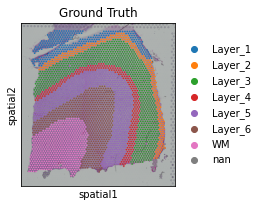

In [12]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

## Constructing the spatial network

------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


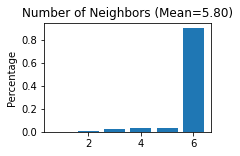

In [13]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata)

## Running STAGATE

In [14]:
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (3460, 3000)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.60it/s]


In [15]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)

In [16]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

Adjusted rand index = 0.60


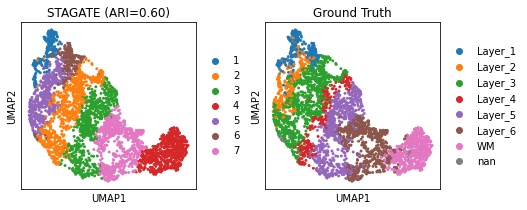

In [17]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

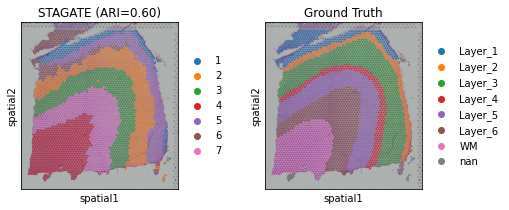

In [18]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

## Spatial trajectory inference (PAGA)

In [19]:
used_adata = adata[adata.obs['Ground Truth']!='nan',]
used_adata

View of AnnData object with n_obs × n_vars = 3431 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Ground Truth_colors', 'Spatial_Net', 'neighbors', 'umap', 'mclust_colors'
    obsm: 'spatial', 'STAGATE', 'X_umap'
    obsp: 'distances', 'connectivities'

In [20]:
sc.tl.paga(used_adata, groups='Ground Truth')

Trying to set attribute `.uns` of view, copying.


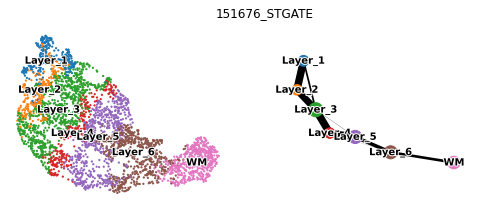

In [21]:
plt.rcParams["figure.figsize"] = (4,3)
sc.pl.paga_compare(used_adata, legend_fontsize=10, frameon=False, size=20,
                   title=section_id+'_STGATE', legend_fontoutline=2, show=False)